# Introduction to NengoSPA

This tutorial introduces the usage of NengoSPA. It expects some basic familarity with
[Nengo](https://www.nengo.ai/nengo/). If you have used the legacy SPA implementation
shipped with core Nengo, you might want to read [this alternate
introduction](intro-coming-from-legacy-spa.ipynb).

We recommend to `import nengo_spa as spa`. (Note that this uses an underscore in the
module name and is different from `nengo.spa` which refers to the legacy SPA module
shipped with core Nengo.)

In [1]:
from __future__ import print_function

%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

import nengo_spa as spa

seed = 0
rng = np.random.RandomState(seed + 1)

We will have to specify the dimensionality of the Semantic Pointers. To make it easy to
change in all places, we define the variable *d* here and set it to 32. A dimensionality
of 32 is on the lower end (in most actual models you will want to use at least 64
dimensions and we have been using up to 512 dimensions), but it makes the examples in
this introduction run faster.

In [2]:
d = 32

## Hello world

Let us start with a very simple model to demonstrate the basic usage of NengoSPA:

In [3]:
with spa.Network(seed=seed) as model:
    stimulus = spa.Transcode("Hello", output_vocab=d)
    state = spa.State(vocab=d)
    nengo.Connection(stimulus.output, state.input)
    p = nengo.Probe(state.output, synapse=0.01)

The first thing to notice is that instead of `nengo.Network`, we use `spa.Network` here.
This allows use to more easily use Nengo's config system for NengoSPA (something we will
look at in more detail later). Then we instantiate two networks `spa.Transcode` and
`spa.State`. These networks are aware of Semantic Pointer inputs and/or outputs. Such
networks we also call (SPA) modules. The `Transcode` module is similar to a
`nengo.Node`. Here it is given a the constant Semantic Pointer *Hello* and it will
output this pointer during the whole simulation. The `State` module is a network of
Nengo ensembles that is optimized for representing (unit-length) Semantic Pointers. Both
of these modules have a *vocab*-like argument which is short for *vocabulary*. In the
context of NengoSPA a vocabulary is a set of Semantic Pointers with a certain
dimensionality. Here we just use the default vocabulary with dimensionality *d*. The
required Semantic Pointers (in this example *Hello*) will be automatically added to that
vocabulary.

Modules can be used like normal Nengo networks. Thus, we can create a connection from
the output of *stimulus* to the input of *state* and then probe the output of *state*.

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Now, let us plot the probed data:

Text(0.5, 0, 'Time [s]')

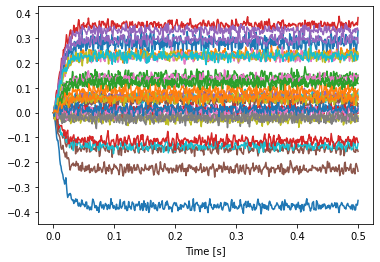

In [5]:
plt.plot(sim.trange(), sim.data[p])
plt.xlabel("Time [s]")

This plot displays the raw vector components of the represented Semantic Pointer and is
not extremely helpful. A useful function to get a more informative plot is
`spa.similarity`. It takes the probe data and a vocabulary as arguments, and returns the
similarity of the data to each Semantic Pointer in the vocabulary. We can access the
vocabulary with the *vocab* attribute of the `State` module.

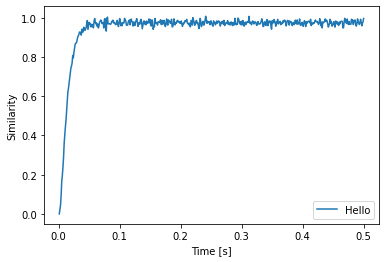

In [6]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], state.vocab))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(state.vocab, loc="best")

We see that input Pointer is successfully represented.

## SPA syntax

One of the main features of `nengo_spa` is a special syntax that makes it easier to
construct large SPA models. Let us demonstrate this with a slightly more complicated
example where we take represent a scene by a Semantic Pointer `BLUE * CIRCLE + RED *
SQUARE` (`*` denotes circular convolution here) and use another input to selectively
retrieve the color of one of the objects.

In [7]:
with spa.Network(seed=seed) as model:
    scene = spa.Transcode("BLUE * CIRCLE + RED * SQUARE", output_vocab=d)
    query = spa.Transcode(lambda t: "CIRCLE" if t < 0.25 else "SQUARE", output_vocab=d)
    result = spa.State(vocab=d)

    scene * ~query >> result

    p = nengo.Probe(result.output, synapse=0.01)

We see that the `Transcode` object also accepts functions like a Nengo `Node`. But the
really interesting line is:

```python
scene * ~query >> result
```

This line is all that is needed to construct a network inverting a circular convolution
(`*` is the circular convolution, `~` inverts `query`), connect `scene` and `query` as
inputs, and then connect the output to result (`>>`).

If we run the model, we see that is successfully decodes `BLUE` and `RED`.

In [8]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

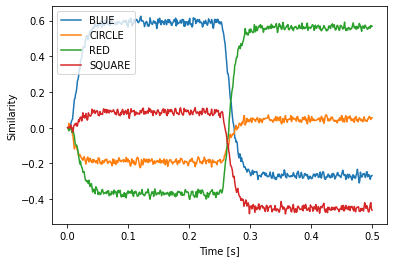

In [9]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], result.vocab))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(result.vocab, loc="best")

Besides circular convolution (`*`) and the approximate inverse (`~`), you can use `*`
also to scale with vectors with a fixed scalar or multiply to scalars, `+` and `-` to
add and subtract Semantic Pointers, and `@` to compute a dot product. To compute a
dot product with older python versions use the `spa.dot` function.

### Symbols

So far we used the `Transcode` network to provide fixed inputs to the network. But there
is a second method that sometimes means less typing.

In [10]:
with spa.Network(seed=seed) as model:
    query = spa.Transcode(lambda t: "CIRCLE" if t < 0.25 else "SQUARE", output_vocab=d)
    result = spa.State(vocab=d)

    ((spa.sym.BLUE * spa.sym.CIRCLE + spa.sym.RED * spa.sym.SQUARE) * ~query >> result)

    p = nengo.Probe(result.output, synapse=0.01)

The `spa.sym` object is a special object on which you can access arbitrary attributes
that will magically return symbolic representations of Semantic Pointers that can be
combined with the usual operators among each other or with SPA modules which will cause
the required neural networks to be implemented.

`spa.sym` can also be called as a function:

In [11]:
with spa.Network(seed=seed) as model:
    query = spa.Transcode(lambda t: "CIRCLE" if t < 0.25 else "SQUARE", output_vocab=d)
    result = spa.State(vocab=d)

    spa.sym("BLUE * CIRCLE + RED * SQUARE") * ~query >> result

    p = nengo.Probe(result.output, synapse=0.01)

### Action selection

Often it is necessary to choose one action out of a number of potential actions. This
can be done with the `ActionSelection` object. It is used as a context manager und
within its context `ifmax` function calls define the potential actions. You can pass an
optional name as first argument to `ifmax`, but you don't have to. The next argument is
an expression that determines the utility value for the action being defined. The
remaining arguments define where things should be routed, if the action's utility value
is the highest of all the actions defined in the `ActionSelection` context.

In this example, we use this to cycle through a sequence of Semantic Pointers.
Initially, we feed `A` into `state` to start things off and then we compute the dot
product of the Semantic Pointer in `state` with the candidates and feed the next
Semantic Pointer in the sequence to `state` accordingly.

In [12]:
def start(t):
    if t < 0.05:
        return "A"
    else:
        return "0"


with spa.Network(seed=seed) as model:
    state = spa.State(d)
    spa_input = spa.Transcode(start, output_vocab=d)

    spa_input >> state
    with spa.ActionSelection():
        spa.ifmax(spa.dot(state, spa.sym.A), spa.sym.B >> state)
        spa.ifmax(spa.dot(state, spa.sym.B), spa.sym.C >> state)
        spa.ifmax(spa.dot(state, spa.sym.C), spa.sym.D >> state)
        spa.ifmax(spa.dot(state, spa.sym.D), spa.sym.E >> state)
        spa.ifmax(spa.dot(state, spa.sym.E), spa.sym.A >> state)

    p = nengo.Probe(state.output, synapse=0.01)

In [13]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Text(0, 0.5, 'Similarity')

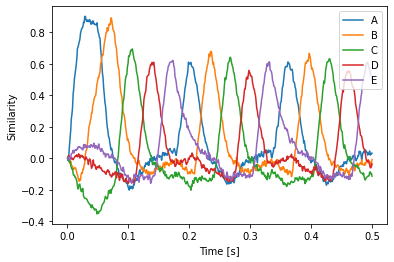

In [14]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], state.vocab))
plt.legend(state.vocab.keys())
plt.xlabel("Time [s]")
plt.ylabel("Similarity")

## Using Transcode for computation

As mentioned before, the `Transcode` object is the analog to the Nengo `Node`. That
means you can also use it for computation implemented in Python code. Let us take one of
the previous examples, but implement the approximate inverse of the circular convolution
in Python code. Note that `scene` and `x` are both SPA symbols, so the operations `*`
and `~` still apply as defined in the SPA syntax.

In [15]:
with spa.Network(seed=seed) as model:
    scene = spa.sym.BLUE * spa.sym.CIRCLE + spa.sym.RED * spa.sym.SQUARE
    unbind = spa.Transcode(lambda t, x: scene * ~x, input_vocab=d, output_vocab=d)
    query = spa.Transcode(lambda t: "CIRCLE" if t < 0.25 else "SQUARE", output_vocab=d)
    result = spa.State(vocab=d)

    query >> unbind
    unbind >> result

    p = nengo.Probe(result.output, synapse=0.01)

In [16]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

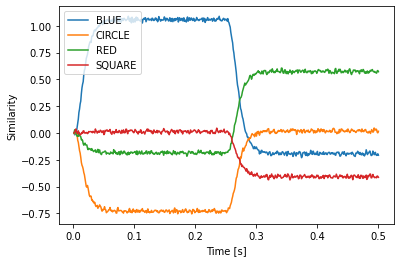

In [17]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], result.vocab))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(result.vocab, loc="best")

## Using the config system with NengoSPA

When building networks with NengoSPA there is a number of parameters that will be set to
predetermined values. Sometimes you might want to change these values. That can be done
with the Nengo config system. In this example, we change the number of neurons
implementing a `State`. Because we reduce the number of neurons by a lot, the start of
the result will look much noisier.

In [18]:
with spa.Network(seed=seed) as model:
    model.config[spa.State].neurons_per_dimension = 10

    state = spa.State(d)
    spa.sym.A >> state

    p = nengo.Probe(state.output, synapse=0.01)

In [19]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Text(0, 0.5, 'Similarity')

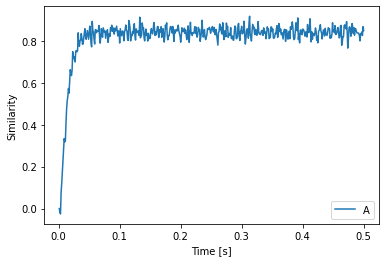

In [20]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], state.vocab))
plt.legend(state.vocab.keys())
plt.xlabel("Time [s]")
plt.ylabel("Similarity")

## Vocabularies

Sometimes you will have sets of unrelated Semantic Pointers. It can be useful to keep
them in distinct groups called *vocabularies*. You can create a vocabulary by
instantiating a `spa.Vocabulary` object with the desired dimensionality. To fill it with
Semantic Pointers, you can use the `populate` method which takes a string of Semantic
Pointer names separated with semicolons. The vocabulary object will try to keep the
maximum similarity between all pointers below a certain threshold (0.1 by default).

In [21]:
vocab = spa.Vocabulary(32, pointer_gen=rng)
vocab.populate("BLUE; RED; CIRCLE; SQUARE")

If you happen to have a Python list of names, that can also be passed easily to
`populate` with a little trick:

In [22]:
list_of_names = ["GREEN", "YELLOW"]
vocab.populate(";".join(list_of_names))

You can also construct Semantic Pointers out of others.

In [23]:
vocab.populate(
    """
    PURPLE = BLUE + RED;
    COLOR_MIX_1 = 0.8 * GREEN + 0.5 * YELLOW;
    SQUARING_THE_CIRCLE = CIRCLE * SQUARE"""
)

Note that these Semantic Pointers will not be normalized to unit length. If you desire
so, call `normalized()` on the constructed pointer. You can also use `unitary()` to get
unitary Semantic Pointers.

In [24]:
vocab.populate(
    """
    NORM_PURPLE = (BLUE + RED).normalized();
    UNITARY1.unitary();
    UNITARY2 = (SQUARE * CIRCLE).unitary()"""
)

Sometimes you might already have a vector that you want to use as a Semantic Pointer
instead of a randomly constructed one. These can be added to a vocabulary with the `add`
method. Note, that this will not ensure the maximum similarity constraint.

In [25]:
v = np.zeros(32)
vocab.add("NULL", v)

Vocabularies work like dictionaries. That means you can retrieve all contained Semantic
Pointers with `keys()` and use indexing with Semantic Pointer names to retrieve specific
pointers as `SemanticPointer` objects. Those specific pointers support the associated
arithmetic operations (e.g., `+` for superposition, `*` for circular convolution). They
can also be used in the SPA syntax, for example to provide them as input to modules. To
access the actual vector use the `v` attribute.

In [26]:
print(list(vocab.keys()))

['BLUE', 'RED', 'CIRCLE', 'SQUARE', 'GREEN', 'YELLOW', 'PURPLE', 'COLOR_MIX_1', 'SQUARING_THE_CIRCLE', 'NORM_PURPLE', 'UNITARY1', 'UNITARY2', 'NULL']


In [27]:
blue = vocab["BLUE"]
print(blue.v)
print((blue * vocab["RED"]).v)

[ 0.29037237 -0.10935923 -0.09441741 -0.19180677  0.15470261 -0.41142928
  0.31190727 -0.1360754   0.05703229 -0.04457812  0.26137037 -0.36827633
 -0.05763617 -0.0686546   0.20267569 -0.19661954 -0.03082373 -0.15692835
  0.00754624  0.10418562 -0.19674966  0.20463391  0.1611708   0.08982725
  0.16103945 -0.12222504 -0.02196819 -0.16728068 -0.0478884   0.09480778
 -0.12364315 -0.07092473]
[-2.33592906e-01  1.20230697e-01 -1.81461860e-01  1.51189322e-01
 -3.02394960e-02  1.80646918e-01  2.04080856e-02  2.67529926e-01
 -1.71525203e-01 -1.49076698e-01 -3.89136163e-01  7.70771473e-02
  1.03376788e-02 -1.84943800e-02 -2.78839585e-02  3.48011970e-01
  4.95260398e-02  2.66837761e-02 -1.65875900e-01  5.28879043e-02
 -1.97860208e-01  3.28975664e-01 -3.15501481e-01 -1.57759818e-01
  6.05768126e-03  2.02859688e-01 -3.12011730e-01  7.45078372e-02
 -1.87441936e-01  2.31766730e-01 -5.49585899e-02  2.16370278e-04]


A vocabulary can also parse more complex expressions and return the resulting Semantic
Pointer.

In [28]:
print(vocab.parse("BLUE * RED").v)

[-2.33592906e-01  1.20230697e-01 -1.81461860e-01  1.51189322e-01
 -3.02394960e-02  1.80646918e-01  2.04080856e-02  2.67529926e-01
 -1.71525203e-01 -1.49076698e-01 -3.89136163e-01  7.70771473e-02
  1.03376788e-02 -1.84943800e-02 -2.78839585e-02  3.48011970e-01
  4.95260398e-02  2.66837761e-02 -1.65875900e-01  5.28879043e-02
 -1.97860208e-01  3.28975664e-01 -3.15501481e-01 -1.57759818e-01
  6.05768126e-03  2.02859688e-01 -3.12011730e-01  7.45078372e-02
 -1.87441936e-01  2.31766730e-01 -5.49585899e-02  2.16370278e-04]


### Creating subsets of vocabularies

In some cases it is useful to create a smaller subset from an existing vocabulary. This
subset will use exactly the same vectors as in the original vocabulary.

In [29]:
just_colors = vocab.create_subset(["BLUE", "RED", "GREEN", "YELLOW", "PURPLE"])
print(list(just_colors.keys()))

['BLUE', 'RED', 'GREEN', 'YELLOW', 'PURPLE']


### Using vocabularies

To use a manually created vocabulary in a model, pass it instead of the dimensionality
to the module.

In [30]:
with spa.Network() as model:
    state = spa.State(vocab)

### Strict mode

Vocabularies that are manually instantiated will be in strict mode per default. That
means trying to access a Semantic Pointer that does not exist in the vocabulary gives an
exception. That can sometimes catch spelling mistakes.

In [31]:
try:
    vocab.parse("UNKNOWN")
except spa.exceptions.SpaParseError as err:
    print(err)

Error parsing expression 'UNKNOWN' with 32-dimensional vocab  at 0x7f1075aa9f70: name 'UNKNOWN' is not defined


In some cases, however, it is more useful to have unknown Semantic Pointers added to the
vocabulary automatically. This happens when a vocabulary is created in non-strict mode.

In [32]:
non_strict_vocab = spa.Vocabulary(32, strict=False)
non_strict_vocab.parse("UNKNOWN")

SemanticPointer(array([ 0.07913094,  0.10078531,  0.13879982,  0.29690737, -0.19026915,
       -0.22988261,  0.00715086,  0.02121388,  0.05514268,  0.08256244,
       -0.14690477,  0.32214103, -0.07238899,  0.15708512,  0.21678787,
        0.15400449, -0.29093543, -0.36521131,  0.21396055,  0.19715409,
        0.04109584,  0.23113396,  0.12493312, -0.03672708, -0.18588779,
       -0.0174775 ,  0.23159449,  0.00839069,  0.00560407,  0.29511521,
       -0.00684496, -0.01704141]), vocab=<nengo_spa.vocabulary.Vocabulary object at 0x7f1075aa2070>, algebra=<nengo_spa.algebras.hrr_algebra.HrrAlgebra object at 0x7f1080fb66a0>, name='UNKNOWN'

The default vocabularies in NengoSPA that are being used whenever you just specify the
dimensionality for a module will be in non-strict mode.

### Converting between vocabularies

When you want to combine Semantic Pointers from different vocabularies in any way, you
will need to convert the Semantic Pointers from one vocabulary to the other vocabulary.
There are different methods to do so.

First, you can use `reinterpret` to indicate that Semantic Pointers from one vocabulary
should be interpreted in the context of another vocabulary without any change the actual
represented vector. That requires both vocabularies to have the same dimensionality.

In [33]:
with spa.Network() as model:
    color = spa.State(just_colors)
    state = spa.State(vocab)
    spa.reinterpret(color, vocab) >> state

Second, you can use 'translate' to find a linear transform that tries to project the
Semantic Pointers from one vocabulary to Semantic Pointers in the other vocabulary based
on the names. This can be useful to use different dimensionalities for the same Semantic
Pointers in different parts of your model.

In [34]:
pointers = "ONE; TWO; THREE"

low_d = spa.Vocabulary(32)
low_d.populate(pointers)

high_d = spa.Vocabulary(128)
high_d.populate(pointers)

In [35]:
with spa.Network() as model:
    low_d_state = spa.State(low_d)
    high_d_state = spa.State(high_d)
    spa.translate(low_d_state, high_d) >> high_d_state

## Clean up memories

The unbinding of a vector is only an approximate inverse. That means the result will
contain some noise that in some cases needs to be removed. This can be done with
clean-up or associative memories (a clean-up memory is basically an auto-associative
memory). NengoSPA provides a number of different variants of such associative memories.
Here we demonstrate the clean-up with a `ThresholdingAssocMem`. It simply removes all
vector components below a certain threshold (here `0.2`).

An associative memory needs to be provided with a vocabulary and all potential Semantic
Pointers that it could clean up to with the `mapping` parameter. The `mapping`
parameters allows to specify hetero-associative mappings, but here we just provide a
sequence of keys which will create an auto-associative mapping.

Note that this subset is considered to be a different vocabulary than the default
vocabulary itself. That means a simple `result >> am` will not work. But we know that
both vocabularies use exactly the same vectors (because we created one as subset from
the other) and thus can reinterpret the Semantic Pointer from `result` in the subset
vocabulary. This is done with `spa.reinterpret(result) >> am`. In this case we do not
need to provide the vocabulary as argument to `spa.reinterpret` because it can be
determined from the context. Keep in mind that this might not work in all cases and give
an exception. Then you have to explicitly add the vocabulary as argument to
`spa.reinterpret`.

In [36]:
with spa.Network(seed=seed) as model:
    scene = spa.Transcode("BLUE * CIRCLE + RED * SQUARE", output_vocab=d)
    query = spa.Transcode(lambda t: "CIRCLE" if t < 0.25 else "SQUARE", output_vocab=d)
    result = spa.State(d)
    am = spa.ThresholdingAssocMem(0.2, input_vocab=d, mapping=["BLUE", "RED"])

    scene * ~query >> result
    spa.reinterpret(result) >> am

    p_result = nengo.Probe(result.output, synapse=0.01)
    p_am = nengo.Probe(am.output, synapse=0.01)

In [37]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Text(0.5, 0, 'Times [s]')

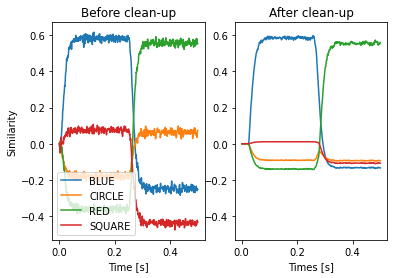

In [38]:
plt.subplot(1, 2, 1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_result], model.vocabs[d]))
plt.title("Before clean-up")
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(model.vocabs[d], loc="lower left")

plt.subplot(1, 2, 2, sharey=plt.gca())
plt.plot(sim.trange(), spa.similarity(sim.data[p_am], model.vocabs[d]))
plt.title("After clean-up")
plt.xlabel("Times [s]")

## What is next?

This introduction gave a short overview of the core NengoSPA features. But there is a
lot more to most of them. Thus, you might want to delve deeper into certain parts of the
documentation that are relevant to you or look at specific examples.